# Imports

In [34]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,plot_confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns

# Carregamento e Pré-Processamento dos Dados

In [35]:
ds = pd.read_csv('../datasets/compas-propublica/compas-scores-two-years.csv')

def preProcess(ds):
    # select African-American and Caucasian people
    ds = ds[(ds['race'] == 'African-American') | (ds['race'] == 'Caucasian')]
    
    # drop duplicated feature columns
    ds.drop(ds[['decile_score.1', 'screening_date', 'v_screening_date', 'priors_count.1']], axis=1, inplace=True)

    # convert dates in string to date/time format
    ds['compas_screening_date'] = pd.to_datetime(ds['compas_screening_date'])
    ds['dob'] = pd.to_datetime(ds['dob'])
    ds['c_jail_in'] = pd.to_datetime(ds['c_jail_in'])
    ds['c_jail_out'] = pd.to_datetime(ds['c_jail_out'])
    ds['c_offense_date'] = pd.to_datetime(ds['c_offense_date'])
    ds['c_arrest_date'] = pd.to_datetime(ds['c_arrest_date'])
    ds['r_offense_date'] = pd.to_datetime(ds['r_offense_date'])
    ds['r_jail_in'] = pd.to_datetime(ds['r_jail_in'])
    ds['r_jail_out'] = pd.to_datetime(ds['r_jail_out'])
    ds['vr_offense_date'] = pd.to_datetime(ds['vr_offense_date'])
    ds['in_custody'] = pd.to_datetime(ds['in_custody'])
    ds['out_custody'] = pd.to_datetime(ds['out_custody'])

    # converting sex categorical variable in numeric variable
    sex = {'Female':1, 'Male':2}
    ds['sex'] = ds['sex'].map(sex)
    # converting race categorical variable in numeric variable
    race = {'African-American':1, 'Caucasian':2}
    ds['race'] = ds['race'].map(race)
    # converting c_charge_degree categorical variable in numeric variable
    c_charge_degree = {'F':1, 'M':2}
    ds['c_charge_degree'] = ds['c_charge_degree'].map(c_charge_degree)
    # converting r_charge_degree and vr_charge_degree categorical variables in numeric variables
    r_vr_charge_degree = {np.nan:0, '(CO3)':1, '(F1)':2, '(F2)':3, '(F3)':4, '(F5)':5, '(F6)':6, '(F7)':7, '(M1)':8, '(M2)':9, '(MO3)':10}
    ds['r_charge_degree'] = ds['r_charge_degree'].map(r_vr_charge_degree)
    ds['vr_charge_degree'] = ds['vr_charge_degree'].map(r_vr_charge_degree)

    # replace nan values in number 1000
    ds['days_b_screening_arrest'] = [1000 if np.isnan(days) else days for days in ds['days_b_screening_arrest']]
    ds['r_days_from_arrest'] = [1000 if np.isnan(days) else days for days in ds['r_days_from_arrest']]

    # calculate the prison days and turns into int values type
    ds['prison_days'] = (ds['c_jail_out'] - ds['c_jail_in'])
    ds['prison_days'] = [str(days).split()[0] for days in ds['prison_days']]
    ds['prison_days'] = [1000 if days=='NaT' else int(days) for days in ds['prison_days']]
    ds['prison_days'] = pd.to_numeric(ds['prison_days'])

    # calculate the custody days and turns into int values type
    ds['custody_days'] = (ds['out_custody'] - ds['in_custody'])
    ds['custody_days'] = [str(days).split()[0] for days in ds['custody_days']]
    ds['custody_days'] = [1000 if days=='NaT' else int(days) for days in ds['custody_days']]
    ds['custody_days'] = pd.to_numeric(ds['custody_days'])

    # classificate medium and high score like highscore and convert to 0 and 1
    ds['score_binary'] = np.where(ds['score_text'] != 'Low', 1, 0)

    return ds

ds = preProcess(ds)

C:\Users\rodolfo\AppData\Local\Temp\ipykernel_2964\2175934616.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.drop(ds[['decile_score.1', 'screening_date', 'v_screening_date', 'priors_count.1']], axis=1, inplace=True)
C:\Users\rodolfo\AppData\Local\Temp\ipykernel_2964\2175934616.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['compas_screening_date'] = pd.to_datetime(ds['compas_screening_date'])
C:\Users\rodolfo\AppData\Local\Temp\ipykernel_2964\2175934616.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

## Testes de Visualizações

In [36]:
# variaveis categoricas: 'sex', 'race', 'c_charge_degree', 'r_charge_degree', 'vr_charge_degree'

#print(ds['race'].value_counts().to_string())
#print(ds['days_b_screening_arrest'].value_counts().sort_values())

#print(ds['r_days_from_arrest'].isna().sum())

#print(ds[(ds['race'] == 1) | (ds['race'] == 3)]['race'].value_counts())

#print(ds.dtypes)

#print(ds['days_b_screening_arrest'][3])

In [37]:
# for i in range(len(ds)):
#     if ds.loc[i]['priors_count'] != ds.loc[i]['priors_count.1']:
#         print(i, ds.loc[i]['priors_count'], ds.loc[i]['priors_count.1'])

# for i in range(len(ds)):
#     print(i, ds.loc[i]['is_recid'], ds.loc[i]['y_pred'])

In [38]:
# for linha in ds.index:
#     if ds['c_jail_in'][linha] > ds['c_jail_out'][linha]:
#         print(linha, ds['c_jail_in'][linha], ds['c_jail_out'][linha])

# Balanceamento do Dataset

In [39]:
# creating random undersampling model
under_sampler = RandomUnderSampler(random_state=99)

balanced_sex, sex_column = under_sampler.fit_resample(ds.drop(['sex'], axis=1), ds['sex'])
balanced_sex['sex'] = sex_column

balanced_race, race_column = under_sampler.fit_resample(ds.drop(['race'], axis=1), ds['race'])
balanced_race['race'] = race_column

balanced_two_year_recid, two_year_recid_column = under_sampler.fit_resample(ds.drop(['two_year_recid'], axis=1), ds['two_year_recid'])
balanced_two_year_recid['two_year_recid'] = two_year_recid_column

In [40]:
print(balanced_sex['sex'].value_counts())
print(balanced_race['race'].value_counts())
print(balanced_two_year_recid['two_year_recid'].value_counts())

1    1219
2    1219
Name: sex, dtype: int64
1    2454
2    2454
Name: race, dtype: int64
0    2867
1    2867
Name: two_year_recid, dtype: int64


# Seleção dos Atributos de Treino e Rótulo

In [41]:
# # 17 features for classification usage
# data_x = ds[['sex', 'age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']]

# data_y = ds['two_year_recid']

# prev_compas = ds['score_binary']

# Divisão do Dataset para Treino e Teste

In [42]:
# # 6150 total lines

# qtd70 = (len(data_x) * 70) // 100

# # 4305 train lines
# train_x = data_x[:qtd70]
# train_y = data_y[:qtd70]

# # 1845 test lines
# test_x = data_x[qtd70:]
# test_y = data_y[qtd70:]
# test_prev_compas = prev_compas[qtd70:]

In [43]:
def train_test_split(dataset):
    data_x = dataset[['sex', 'age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']]

    data_y = dataset['two_year_recid']

    prev_compas = dataset['score_binary']

    train_test_data = {}

    qtd70 = (len(data_x) * 70) // 100

    # train lines
    train_test_data['train_x'] = data_x[:qtd70]
    train_test_data['train_y'] = data_y[:qtd70]

    # test lines
    train_test_data['test_x'] = data_x[qtd70:]
    train_test_data['test_y'] = data_y[qtd70:]
    train_test_data['test_prev_compas'] = prev_compas[qtd70:]

    return train_test_data

In [44]:
split_dataset = train_test_split(ds)

# creating splits of sex, race and two year recid balanced datasets
split_sex = train_test_split(balanced_sex)
split_race = train_test_split(balanced_race)
split_two_year_recid = train_test_split(balanced_two_year_recid)

# Execução e Resultado dos Modelos

In [45]:
def fit_predict(dataset, features):
    rf = RandomForestClassifier()

    rf.fit(dataset['train_x'][features], dataset['train_y'])
    prev = rf.predict(dataset['test_x'][features])

    # calculating metrics of prevision and true values
    metrics_prevision = []
    metrics_prevision.append(accuracy_score(dataset['test_y'], prev))
    metrics_prevision.append(precision_score(dataset['test_y'], prev))
    metrics_prevision.append(recall_score(dataset['test_y'], prev))
    metrics_prevision.append(confusion_matrix(dataset['test_y'], prev))

    # calculating metrics of prevision and compas prevision
    metrics_compas = []
    metrics_compas.append(accuracy_score(dataset['test_prev_compas'], prev))
    metrics_compas.append(precision_score(dataset['test_prev_compas'], prev))
    metrics_compas.append(recall_score(dataset['test_prev_compas'], prev))
    metrics_compas.append(confusion_matrix(dataset['test_prev_compas'], prev))

    return metrics_prevision, metrics_compas

def plot_bar_graph(graph_title, metrics_prevision, metrics_compas):
    labels = ['Accuracy', 'Precision', 'Recall']

    plt.subplots(figsize=(9, 7))
    plt.title(graph_title + '\n', loc='center', fontsize=15)
    plt.bar(labels, [metrics_prevision[0], metrics_prevision[1], metrics_prevision[2]], width=.5)
    for index, data in enumerate([metrics_prevision[0], metrics_prevision[1], metrics_prevision[2]]):
        plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='white')
    
    plt.bar(labels, [metrics_compas[0], metrics_compas[1], metrics_compas[2]], width=.5)
    for index, data in enumerate([metrics_compas[0], metrics_compas[1], metrics_compas[2]]):
        plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='black')
    plt.legend(labels=['True Values', 'COMPAS Prevision'], loc='lower right')
    plt.ylim(0.5,1.02)

def plot_confusion_matrix_graph(graph_title, matrix_data):
    plt.subplots(figsize=(9, 7))
    sns.heatmap(matrix_data, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={"fontsize":15})
    plt.title(graph_title + '\n', loc='center', fontsize=15)
    plt.xlabel('\nPredict Values', fontsize=15)
    plt.ylabel('True Values\n', fontsize=15)

## Sem Balanceamento

### Execução 1 - Todas os Atributos

Utilizando todos os atributos (17 no total) filtrados favoráveis à classificação.

[0.9680216802168021, 0.9365591397849462, 1.0, array([[915,  59],
       [  0, 871]], dtype=int64)]
[0.6401084010840108, 0.646236559139785, 0.6420940170940171, array([[580, 329],
       [335, 601]], dtype=int64)]


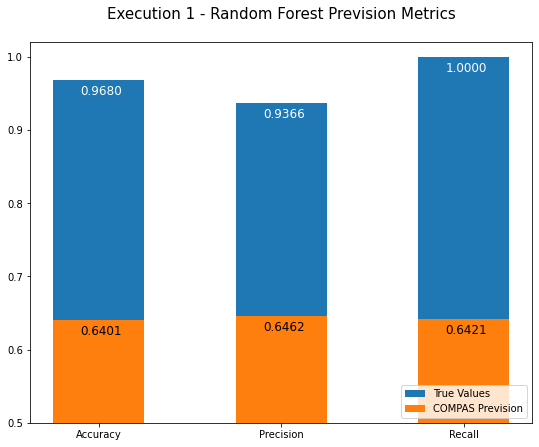

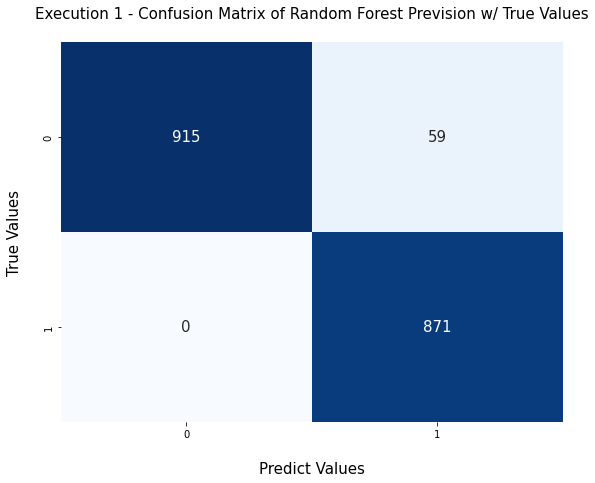

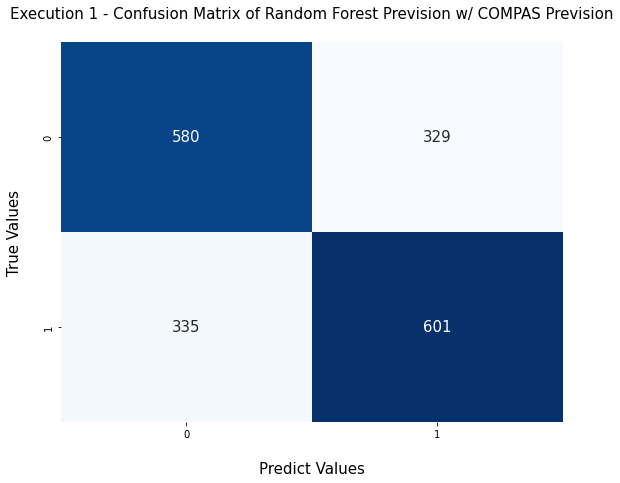

In [46]:
# rf = RandomForestClassifier()
# gb = GradientBoostingClassifier()

# rf.fit(train_x, train_y)
# gb.fit(train_x, train_y)

# ex1_prev_rf = rf.predict(test_x)
# ex1_prev_gb = gb.predict(test_x)

ex1_features = ['sex', 'age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

ex1_metrics_prevision, ex1_metrics_compas = fit_predict(split_dataset, ex1_features)

print(ex1_metrics_prevision)
print(ex1_metrics_compas)

plot_bar_graph('Execution 1 - Random Forest Prevision Metrics',
                ex1_metrics_prevision,
                ex1_metrics_compas)
plot_confusion_matrix_graph('Execution 1 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex1_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 1 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex1_metrics_compas[3])

### Execução 2 - Sem Atributo de Sexo

Retirando a utilização do atributo de sexo, utilizando 16 no total.

[0.967479674796748, 0.9364908503767492, 0.9988518943742825, array([[915,  59],
       [  1, 870]], dtype=int64)]
[0.640650406504065, 0.6469321851453176, 0.6420940170940171, array([[581, 328],
       [335, 601]], dtype=int64)]


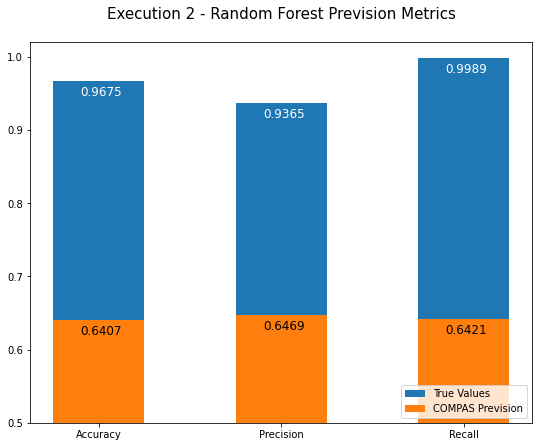

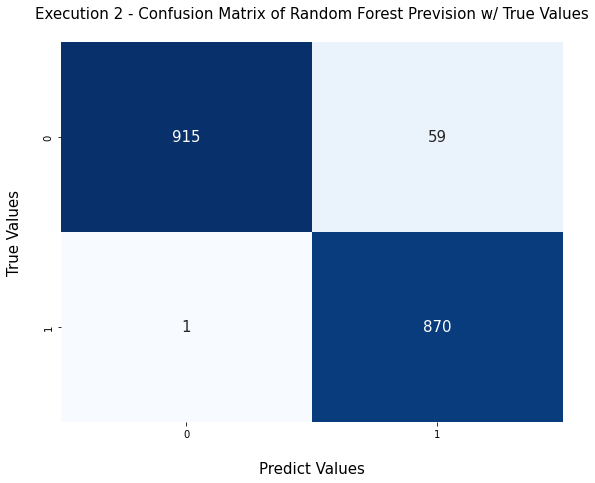

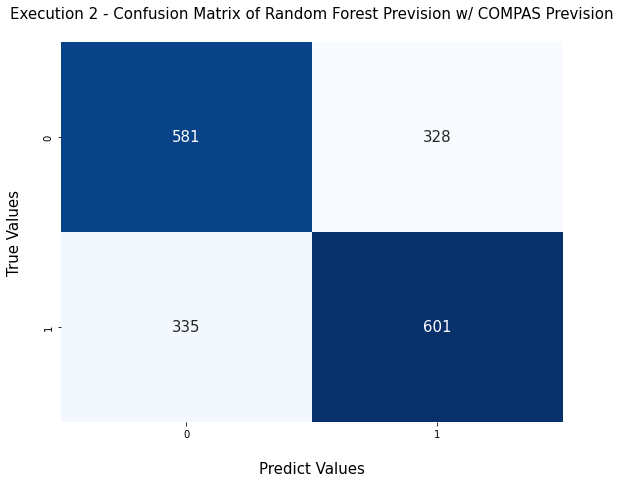

In [47]:
# rf = RandomForestClassifier()
# gb = GradientBoostingClassifier()

# features = ['age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

# rf.fit(train_x[features], train_y)
# gb.fit(train_x[features], train_y)

# ex2_prev_rf = rf.predict(test_x[features])
# ex2_prev_gb = gb.predict(test_x[features])

ex2_features = ['age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

ex2_metrics_prevision, ex2_metrics_compas = fit_predict(split_dataset, ex2_features)

print(ex2_metrics_prevision)
print(ex2_metrics_compas)

plot_bar_graph('Execution 2 - Random Forest Prevision Metrics',
                ex2_metrics_prevision,
                ex2_metrics_compas)
plot_confusion_matrix_graph('Execution 2 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex2_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 2 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex2_metrics_compas[3])

### Execução 3 - Sem Atributo de Raça

Retirando a utilização do atributo de raça, utilizando 16 no total.

[0.9680216802168021, 0.9365591397849462, 1.0, array([[915,  59],
       [  0, 871]], dtype=int64)]
[0.6401084010840108, 0.646236559139785, 0.6420940170940171, array([[580, 329],
       [335, 601]], dtype=int64)]


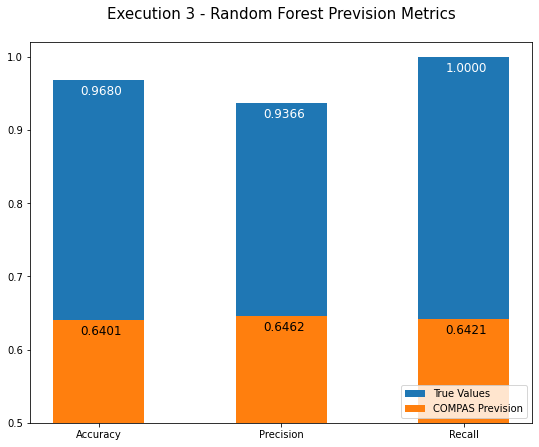

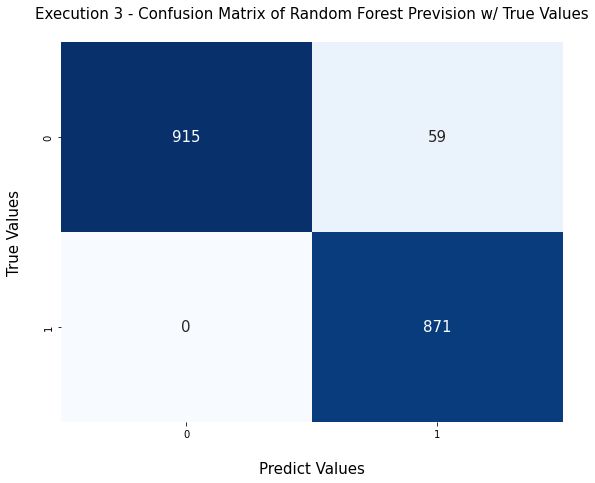

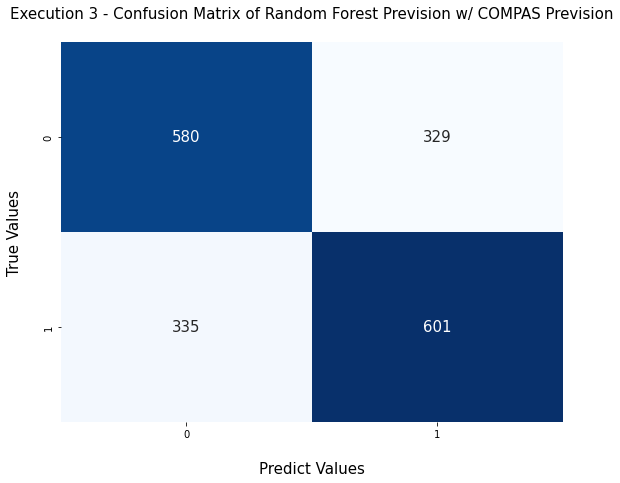

In [48]:
# rf = RandomForestClassifier()
# gb = GradientBoostingClassifier()

# features = ['sex', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

# rf.fit(train_x[features], train_y)
# gb.fit(train_x[features], train_y)

# ex3_prev_rf = rf.predict(test_x[features])
# ex3_prev_gb = gb.predict(test_x[features])

ex3_features = ['sex', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

ex3_metrics_prevision, ex3_metrics_compas = fit_predict(split_dataset, ex3_features)

print(ex3_metrics_prevision)
print(ex3_metrics_compas)

plot_bar_graph('Execution 3 - Random Forest Prevision Metrics',
                ex3_metrics_prevision,
                ex3_metrics_compas)
plot_confusion_matrix_graph('Execution 3 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex3_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 3 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex3_metrics_compas[3])

### Execução 4 - Sem os Atributo de Sexo e Raça

Retirando a utilização dos atributos de sexo e raça, utilizando 15 no total.

[0.9680216802168021, 0.9365591397849462, 1.0, array([[915,  59],
       [  0, 871]], dtype=int64)]
[0.6401084010840108, 0.646236559139785, 0.6420940170940171, array([[580, 329],
       [335, 601]], dtype=int64)]


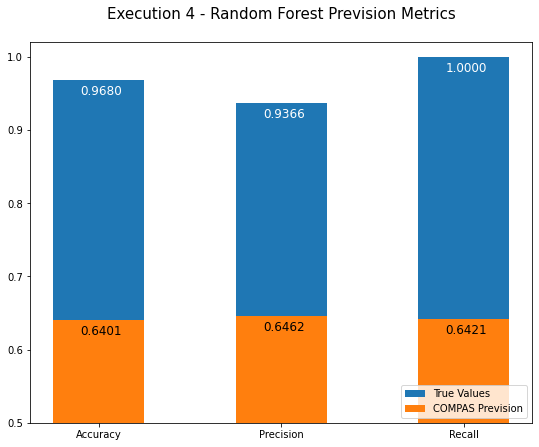

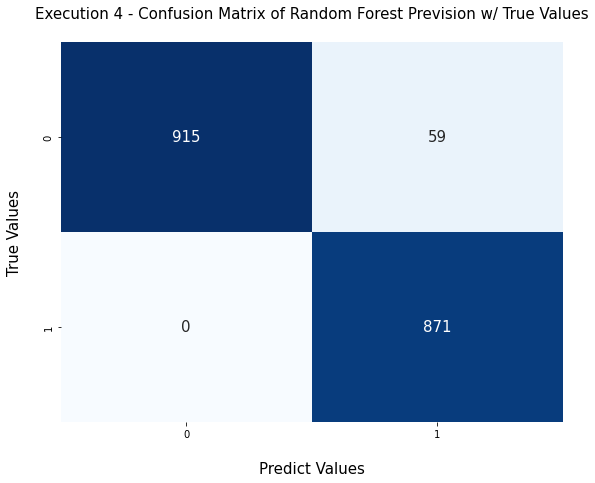

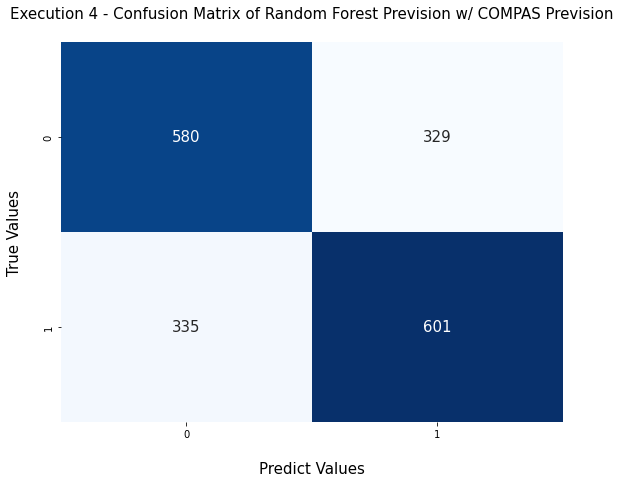

In [49]:
# rf = RandomForestClassifier()
# gb = GradientBoostingClassifier()

# features = ['age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

# rf.fit(train_x[features], train_y)
# gb.fit(train_x[features], train_y)

# ex4_prev_rf = rf.predict(test_x[features])
# ex4_prev_gb = gb.predict(test_x[features])

ex4_features = ['age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

ex4_metrics_prevision, ex4_metrics_compas = fit_predict(split_dataset, ex4_features)

print(ex4_metrics_prevision)
print(ex4_metrics_compas)

plot_bar_graph('Execution 4 - Random Forest Prevision Metrics',
                ex4_metrics_prevision,
                ex4_metrics_compas)
plot_confusion_matrix_graph('Execution 4 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex4_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 4 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex4_metrics_compas[3])

## Balanceamento do Sexo

### Execução 5 - Todas os Atributos

[0.9617486338797814, 0.9301745635910225, 1.0, array([[331,  28],
       [  0, 373]], dtype=int64)]
[0.6270491803278688, 0.6433915211970075, 0.6649484536082474, array([[201, 143],
       [130, 258]], dtype=int64)]


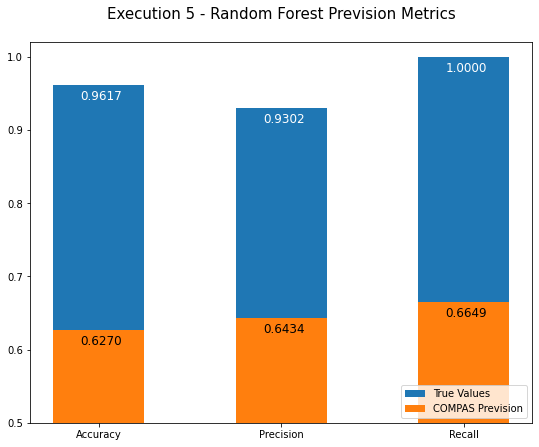

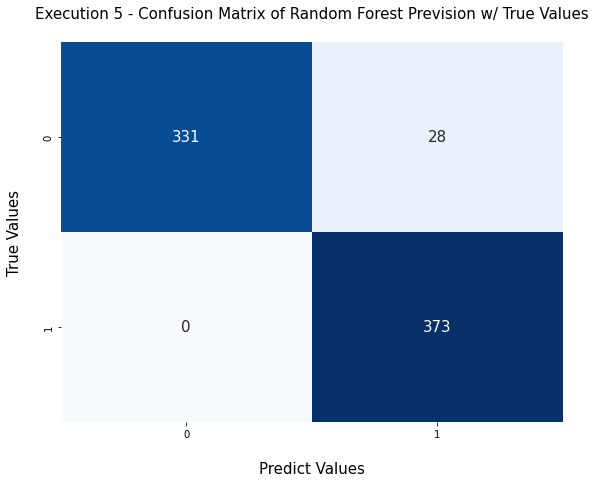

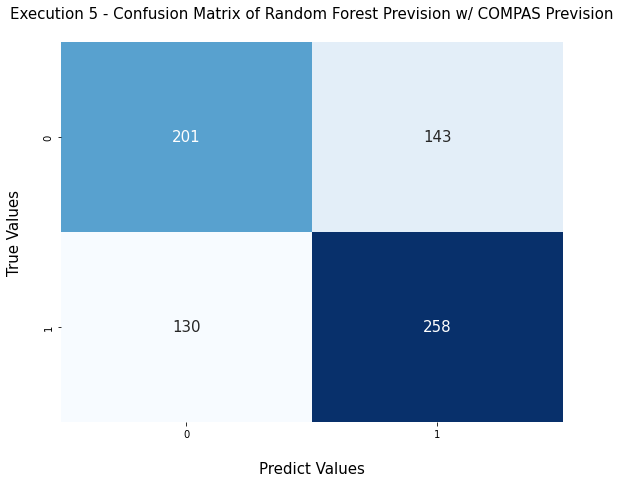

In [50]:
ex5_metrics_prevision, ex5_metrics_compas = fit_predict(split_sex, ex1_features)

print(ex5_metrics_prevision)
print(ex5_metrics_compas)

plot_bar_graph('Execution 5 - Random Forest Prevision Metrics',
                ex5_metrics_prevision,
                ex5_metrics_compas)
plot_confusion_matrix_graph('Execution 5 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex5_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 5 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex5_metrics_compas[3])

### Execução 6 - Sem Atributo de Raça

[0.9617486338797814, 0.9301745635910225, 1.0, array([[331,  28],
       [  0, 373]], dtype=int64)]
[0.6270491803278688, 0.6433915211970075, 0.6649484536082474, array([[201, 143],
       [130, 258]], dtype=int64)]


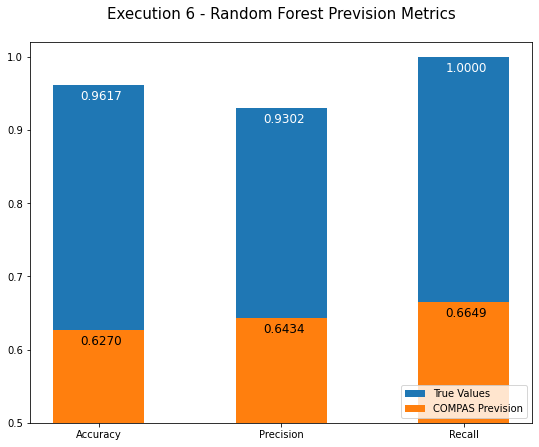

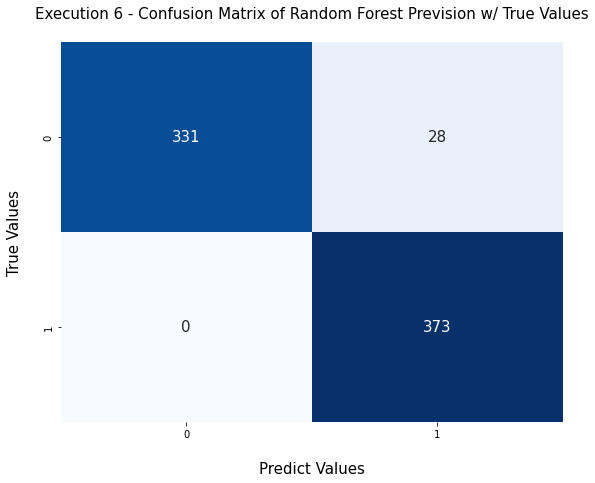

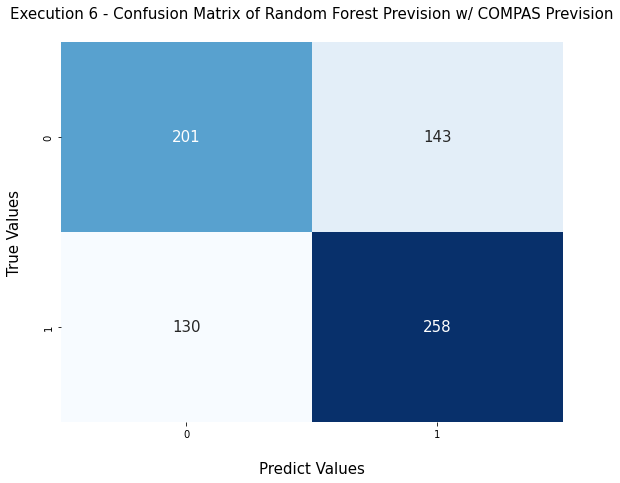

In [51]:
ex6_metrics_prevision, ex6_metrics_compas = fit_predict(split_sex, ex3_features)

print(ex6_metrics_prevision)
print(ex6_metrics_compas)

plot_bar_graph('Execution 6 - Random Forest Prevision Metrics',
                ex6_metrics_prevision,
                ex6_metrics_compas)
plot_confusion_matrix_graph('Execution 6 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex6_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 6 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex6_metrics_compas[3])

## Balanceamento de Raça

### Execução 7 - Todas os Atributos

[0.9728445349626612, 0.9358974358974359, 1.0, array([[849,  40],
       [  0, 584]], dtype=int64)]
[0.6496945010183299, 0.5160256410256411, 0.6007462686567164, array([[635, 302],
       [214, 322]], dtype=int64)]


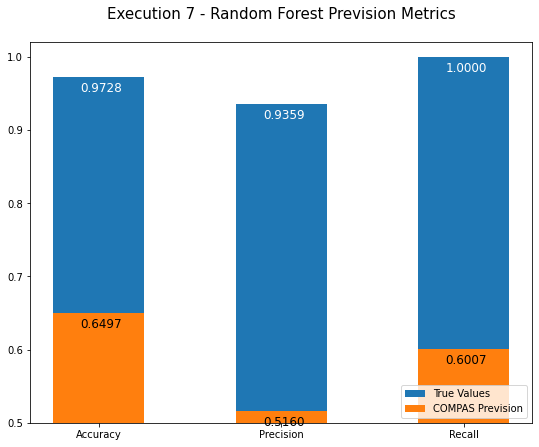

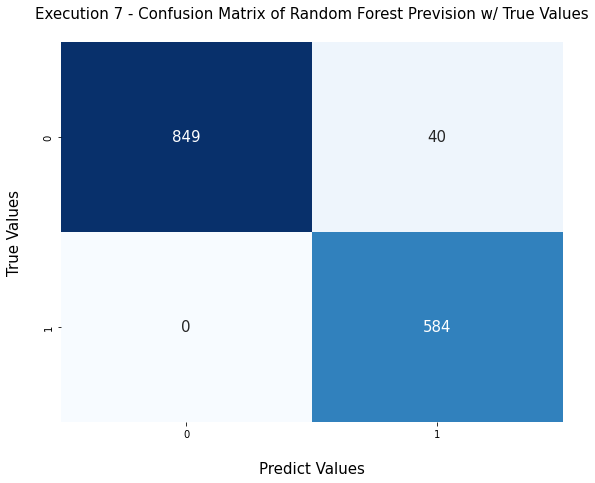

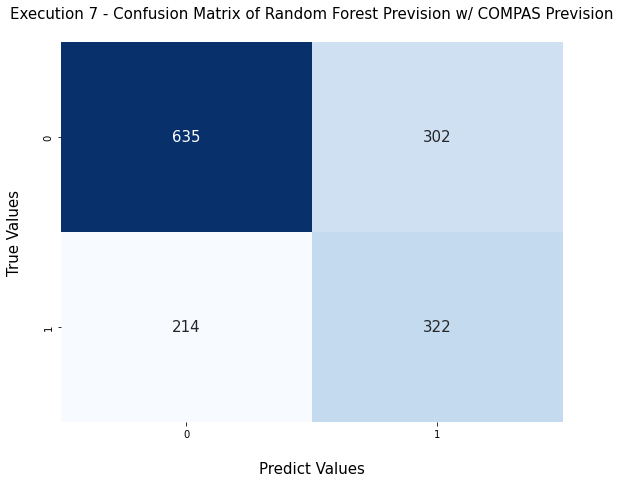

In [52]:
ex7_metrics_prevision, ex7_metrics_compas = fit_predict(split_race, ex1_features)

print(ex7_metrics_prevision)
print(ex7_metrics_compas)

plot_bar_graph('Execution 7 - Random Forest Prevision Metrics',
                ex7_metrics_prevision,
                ex7_metrics_compas)
plot_confusion_matrix_graph('Execution 7 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex7_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 7 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex7_metrics_compas[3])

### Execução 8 - Sem Atributo de Sexo

[0.9728445349626612, 0.9358974358974359, 1.0, array([[849,  40],
       [  0, 584]], dtype=int64)]
[0.6496945010183299, 0.5160256410256411, 0.6007462686567164, array([[635, 302],
       [214, 322]], dtype=int64)]


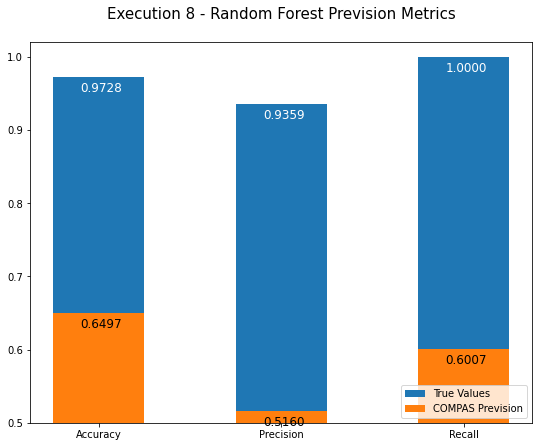

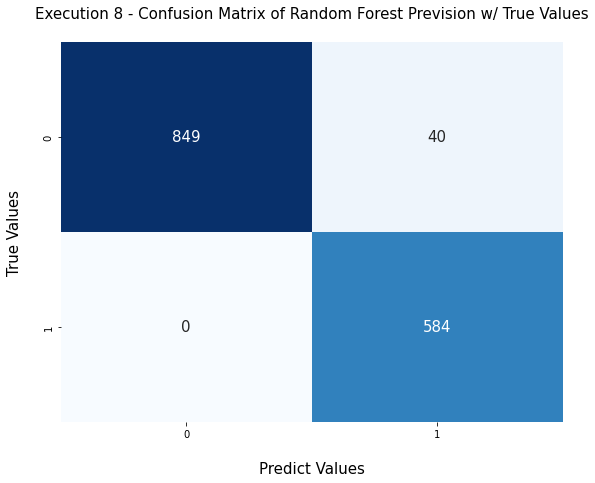

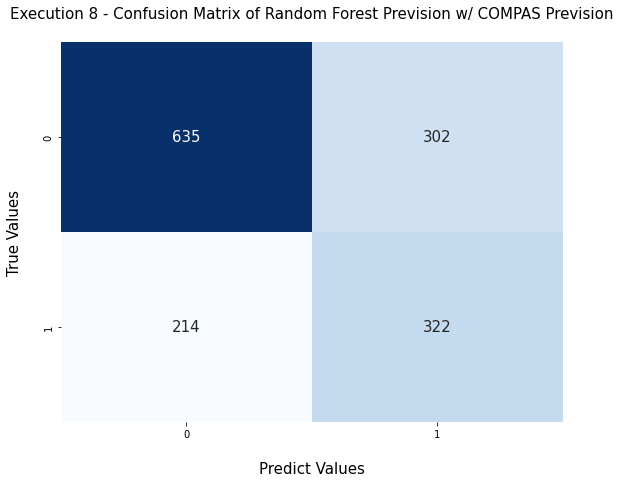

In [53]:
ex8_metrics_prevision, ex8_metrics_compas = fit_predict(split_race, ex2_features)

print(ex8_metrics_prevision)
print(ex8_metrics_compas)

plot_bar_graph('Execution 8 - Random Forest Prevision Metrics',
                ex8_metrics_prevision,
                ex8_metrics_compas)
plot_confusion_matrix_graph('Execution 8 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex8_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 8 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex8_metrics_compas[3])

## Balanceamento de Reincidência

### Execução 9 - Todas os Atributos

[0.9953515398024404, 1.0, 0.9953515398024404, array([[   0,    0],
       [   8, 1713]], dtype=int64)]
[0.6490412550842534, 0.649737302977233, 0.9964189794091316, array([[   4,  600],
       [   4, 1113]], dtype=int64)]


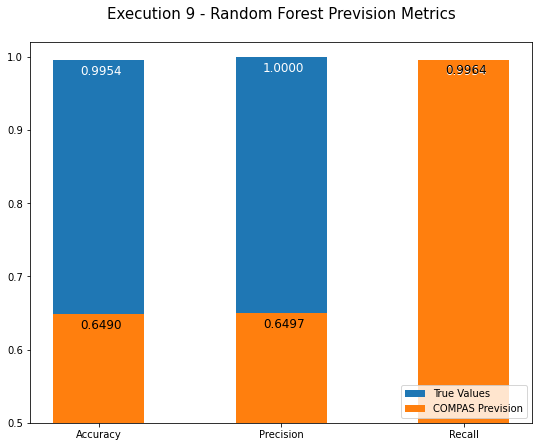

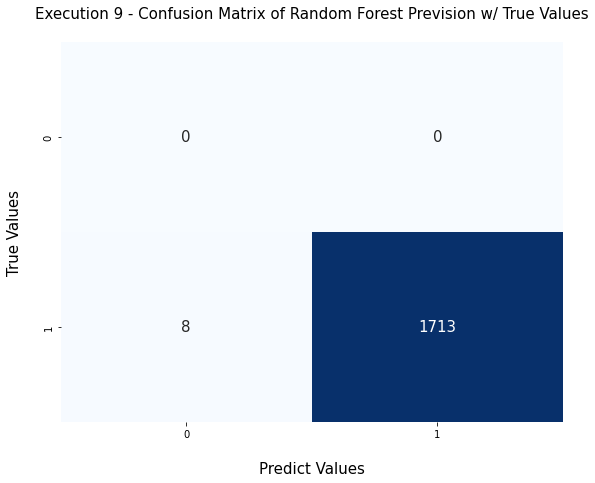

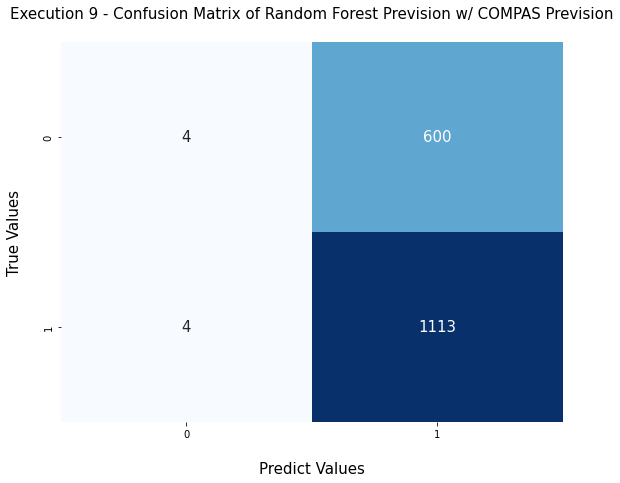

In [54]:
ex9_metrics_prevision, ex9_metrics_compas = fit_predict(split_two_year_recid, ex1_features)
plot_bar_graph('Execution 9 - Random Forest Prevision Metrics',
                ex9_metrics_prevision,
                ex9_metrics_compas)

print(ex9_metrics_prevision)
print(ex9_metrics_compas)

plot_confusion_matrix_graph('Execution 9 - Confusion Matrix of Random Forest Prevision w/ True Values',
                            ex9_metrics_prevision[3])
plot_confusion_matrix_graph('Execution 9 - Confusion Matrix of Random Forest Prevision w/ COMPAS Prevision',
                            ex9_metrics_compas[3])